In [1]:
### Calculate the sessions frequency as follows
# Total Session Frequency = Dur. (ms) / (Activity Duration DL (ms) + Activity Duration UL (ms))

### Calculate Duration of the session as follows
# Downlink Duration = (Total DL (Bytes) / (Avg Bearer TP DL (kbps) / 1000
# Uplink Duration = (Total DL (Bytes) + Avg Bearer TP UL (kbps)) / 1000

# Total Duration (Assuming uplink and downlink took place at different time) = Downlink Duration + Uplink Duraiton

## Imports

In [2]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import STOPWORDS,WordCloud
import gensim
from gensim.models import CoherenceModel
from gensim import corpora
import pandas as pd
from pprint import pprint
import string
import os
import re
import numpy as np 
import pandas as pd 
import re
import nltk 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.datasets import make_multilabel_classification
from sklearn.multioutput import MultiOutputClassifier
import joblib
import seaborn as sns

In [3]:
pd.set_option('display.max_columns', None) ## so that full columns are visible

## Procedures 
1. Data loading
2. Data Cleaning
3. Data transforming
4. Data Extraction
5. EDA

### 1. Data Loading

In [4]:
class DataLoader:
  def __init__(self,dir_name,file_name):
    self.dir_name = dir_name
    self.file_name = file_name
    
 
  def read_csv(self):
    os.chdir(self.dir_name)
    tweets_df=pd.read_csv(self.file_name)
    return tweets_df

data_loader_object = DataLoader('/content/drive/MyDrive/', 'Week1_challenge_data_source(CSV).csv')
raw_data = data_loader_object.read_csv()

### 2. Data Cleaning

In [5]:
len(raw_data["MSISDN/Number"].unique().tolist())

106857

In [6]:
# Get the new data for the task
imp_columns = ["MSISDN/Number", "Frequency", "DL Duration", "UL Duration",
               "Sessions Total UL", "Sessions Total"]
data_pruned = pd.DataFrame(columns=imp_columns)

In [7]:
data_pruned["MSISDN/Number"] = raw_data.groupby("MSISDN/Number").agg({"Bearer Id": "count"}).reset_index()["MSISDN/Number"]
data_pruned["Frequency"] = raw_data.groupby("MSISDN/Number").agg({"Bearer Id": "count"}).reset_index()["Bearer Id"]
data_pruned["DL Duration"] = raw_data.groupby("MSISDN/Number").agg({"Activity Duration DL (ms)": "sum"}).reset_index()["Activity Duration DL (ms)"]
data_pruned["UL Duration"] = raw_data.groupby("MSISDN/Number").agg({"Activity Duration UL (ms)": "sum"}).reset_index()["Activity Duration UL (ms)"]
data_pruned["Sessions Total DL"] = raw_data.groupby("MSISDN/Number").agg({"Total DL (Bytes)": "sum"}).reset_index()["Total DL (Bytes)"]
data_pruned["Sessions Total UL"] = raw_data.groupby("MSISDN/Number").agg({"Total UL (Bytes)": "sum"}).reset_index()["Total UL (Bytes)"]

In [8]:
data_pruned["Sessions Total"] = data_pruned["Sessions Total DL"] + data_pruned["Sessions Total UL"]

In [9]:
data_pruned.isna().sum()

MSISDN/Number        0
Frequency            0
DL Duration          0
UL Duration          0
Sessions Total UL    0
Sessions Total       0
Sessions Total DL    0
dtype: int64

#### Task 2.1

##### Aggregate the above metrics per customer id (MSISDN)

In [10]:
# Top 10 Customers per session frequency
top_10_per_frequency = data_pruned.nlargest(n=10, columns=["Frequency"])

In [11]:
# Top 10 Customers per DL Duration
top_10_per_DL_duration = data_pruned.nlargest(n=10, columns=["DL Duration"])

In [12]:
# Top 10 Customers per UL Duration
top_10_per_UL_duration= data_pruned.nlargest(n=10, columns=["UL Duration"])

In [13]:
# Top 10 Customers per sessions totla
top_10_per_sessions_total= data_pruned.nlargest(n=10, columns=["Sessions Total"])

##### Normalize each engagement metric and run a k-means (k=3) to classify customers in three groups of engagement. 


In [14]:
data_pruned.shape[0] 

106856

In [15]:
from sklearn.preprocessing import MinMaxScaler
def normalizer(df):
  norm = MinMaxScaler()
  # normalize the exponential data with boxcox
  normalized_data = norm.fit_transform(df)
  return normalized_data

def split_and_norm(df):
  columns = df.columns
  step = df.shape[0]//50
  ret_df = pd.DataFrame(columns=columns)
  for i in range(50):
    ndf = df[i*step: (i+1)*step]
    normalized_data = normalizer(ndf)
    print(pd.DataFrame(normalized_data, columns=columns))
    # pd.concat([ret_df, pd.DataFrame(normalized_data, columns=columns)])
  return ret_df

In [16]:
msisdn_value = data_pruned["MSISDN/Number"]
### Saving the data for task 4

data_pruned = data_pruned.drop("MSISDN/Number", axis=1)

In [17]:
new_data = pd.DataFrame(columns=["DL Duration (S)", "UL Duration (S)",
                                 "Sessions Total UL (Mb)", "Sessions Total (Mb)",
                                 "Sessions Total DL (Mb)"])

new_data["DL Duration (S)"] = data_pruned["DL Duration"]/1000
new_data["UL Duration (S)"] = data_pruned["UL Duration"]/1000
new_data["Sessions Total UL (Mb)"] = data_pruned["Sessions Total UL"]/1000000
new_data["Sessions Total (Mb)"] = data_pruned["Sessions Total"]/1000000
new_data["Sessions Total DL (Mb)"] = data_pruned["Sessions Total DL"]/1000000

In [18]:
new_data = normalizer(new_data)

In [19]:
from sklearn.cluster import KMeans
k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(new_data)




In [20]:
engament_centroids = pd.DataFrame(kmeans.cluster_centers_)

In [21]:
engament_centroids.to_csv("engagment_centroids.csv", index=False)

In [22]:
normalized_data = pd.DataFrame(new_data)

In [23]:
normalized_data.to_csv("engagment_data.csv", index=False)

##### Using elbow method to find optimized K

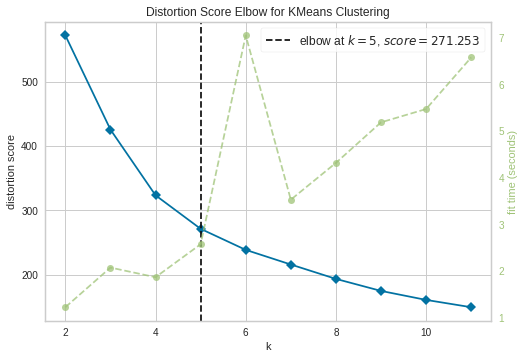

In [25]:
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()

visualizer = KElbowVisualizer(model, k=(2,12))

visualizer.fit(new_data)        # Fit the data to the visualizer
visualizer.show()               # Finalize and render the figure

In [26]:
# Elbow is found at k=5

##### Compute min, max, average and total


In [27]:
data_pruned["Kth Group"] = y_pred

In [28]:
asds = data_pruned.groupby("Kth Group")

In [29]:
data_sorted = data_pruned.sort_values(by=["Kth Group"])

In [30]:
kth_0 = data_sorted[data_sorted["Kth Group"] == 0]
kth_1 = data_sorted[data_sorted["Kth Group"] == 1]
kth_2 = data_sorted[data_sorted["Kth Group"] == 2]

In [31]:
# K=0 Max, Min, Average, total
k_0_max = kth_0.max()
k_0_min = kth_0.min()
k_0_average = kth_0.mean()
k_0_total = kth_0.sum()

# K=1 Max, Min, Average, total
k_1_max = kth_1.max()
k_1_min = kth_1.min()
k_1_average = kth_1.mean()
k_1_total = kth_1.sum()

# K=2 Max, Min, Average, total
k_2_max = kth_2.max()
k_2_min = kth_2.min()
k_2_average = kth_2.mean()
k_2_total = kth_2.sum()

In [41]:
cluster0_mi_max = pd.DataFrame([k_0_max, k_0_min, k_0_average, k_0_total])
cluster1_mi_max = pd.DataFrame([k_1_max, k_1_min, k_1_average, k_1_total])
cluster2_mi_max = pd.DataFrame([k_2_max, k_2_min, k_2_average, k_2_total])

In [42]:
clusters = pd.concat([cluster0_mi_max, cluster1_mi_max])

In [43]:
clusters = pd.concat([clusters, cluster2_mi_max])

In [45]:
clusters.to_csv("clusters.csv", index=False)

In [47]:
clusters[:4]

,Frequency,DL Duration,UL Duration,Sessions Total UL,Sessions Total,Sessions Total DL,Kth Group
0,3.000000,9.528401e+07,9.191319e+07,1.423536e+08,7.492925e+08,7.401162e+08,0.0
1,0.000000,0.000000e+00,0.000000e+00,2.866892e+06,3.324901e+07,8.827082e+06,0.0
2,1.048485,1.379503e+06,1.085813e+06,4.249373e+07,3.859128e+08,3.434191e+08,0.0
3,62561.000000,8.231217e+10,6.478829e+10,2.535516e+12,2.302665e+13,2.049113e+13,0.0


##### Aggregate user total traffic per application and derive the top 10 most engaged users per application


In [48]:
data_pruned["Social Media"] = raw_data.groupby("MSISDN/Number").agg({"Social Media DL (Bytes)": "sum"}).reset_index()["Social Media DL (Bytes)"]+ raw_data.groupby("MSISDN/Number").agg({"Social Media UL (Bytes)": "sum"}).reset_index()["Social Media UL (Bytes)"]
data_pruned["Google"] = raw_data.groupby("MSISDN/Number").agg({"Google DL (Bytes)": "sum"}).reset_index()["Google DL (Bytes)"]+ raw_data.groupby("MSISDN/Number").agg({"Google UL (Bytes)": "sum"}).reset_index()["Google UL (Bytes)"]
data_pruned["Youtube"] = raw_data.groupby("MSISDN/Number").agg({"Youtube DL (Bytes)": "sum"}).reset_index()["Youtube DL (Bytes)"]+ raw_data.groupby("MSISDN/Number").agg({"Youtube UL (Bytes)": "sum"}).reset_index()["Youtube UL (Bytes)"]
data_pruned["Email"] = raw_data.groupby("MSISDN/Number").agg({"Email DL (Bytes)": "sum"}).reset_index()["Email DL (Bytes)"]+ raw_data.groupby("MSISDN/Number").agg({"Email UL (Bytes)": "sum"}).reset_index()["Email UL (Bytes)"]
data_pruned["Netflix"] = raw_data.groupby("MSISDN/Number").agg({"Netflix DL (Bytes)": "sum"}).reset_index()["Netflix DL (Bytes)"]+ raw_data.groupby("MSISDN/Number").agg({"Netflix UL (Bytes)": "sum"}).reset_index()["Netflix UL (Bytes)"]
data_pruned["Gaming"] = raw_data.groupby("MSISDN/Number").agg({"Gaming DL (Bytes)": "sum"}).reset_index()["Gaming DL (Bytes)"]+ raw_data.groupby("MSISDN/Number").agg({"Gaming UL (Bytes)": "sum"}).reset_index()["Gaming UL (Bytes)"]
data_pruned["Other"] = raw_data.groupby("MSISDN/Number").agg({"Other DL (Bytes)": "sum"}).reset_index()["Other DL (Bytes)"]+ raw_data.groupby("MSISDN/Number").agg({"Other UL (Bytes)": "sum"}).reset_index()["Other UL (Bytes)"]

In [49]:
data_pruned["MSISDN/Number"] = msisdn_value

In [50]:
ten_most_social = data_pruned.nlargest(n=10, columns=["Social Media"])["MSISDN/Number"]
ten_most_google = data_pruned.nlargest(n=10, columns=["Google"])["MSISDN/Number"]
ten_most_youtube = data_pruned.nlargest(n=10, columns=["Youtube"])["MSISDN/Number"]
ten_most_email = data_pruned.nlargest(n=10, columns=["Email"])["MSISDN/Number"]
ten_most_netflix = data_pruned.nlargest(n=10, columns=["Netflix"])["MSISDN/Number"]
ten_most_gaming = data_pruned.nlargest(n=10, columns=["Gaming"])["MSISDN/Number"]
ten_most_other = data_pruned.nlargest(n=10, columns=["Other"])["MSISDN/Number"]

In [57]:
ten_most = pd.DataFrame(columns=["Social", "Google", "Youtube", "Email", "Netflix", "Gaming", "Other"])

In [58]:
ten_most["Social"] = ten_most_social
ten_most["Google"] = ten_most_google
ten_most["Youtube"] = ten_most_youtube
ten_most["Email"] = ten_most_email
ten_most["Netflix"] = ten_most_netflix
ten_most["Gaming"] = ten_most_gaming
ten_most["Other"] = ten_most_other

In [59]:
ten_most.to_csv("ten_most.csv", index=False)

##### Plot the top 3 most used applications using appropriate charts. 

In [51]:
# indexing sm, goog, yt, em, nf, gam, oth
application_uses = [("Social Media",data_pruned["Social Media"].sum()), ("Google", data_pruned["Google"].sum()),
                    ("Youtube",data_pruned["Youtube"].sum()), ("Email",data_pruned["Email"].sum()),
                    ("Netflix",data_pruned["Netflix"].sum()), ("Gaming", data_pruned["Gaming"].sum()),
                    ("Other",data_pruned["Other"].sum())]

In [52]:
application_uses.sort(key=lambda y: y[1], reverse=True)

In [53]:
top_three = application_uses[:3]

In [54]:
destructured = list(zip(*top_three))
labels = list(destructured[0])
sizes = list(destructured[1])

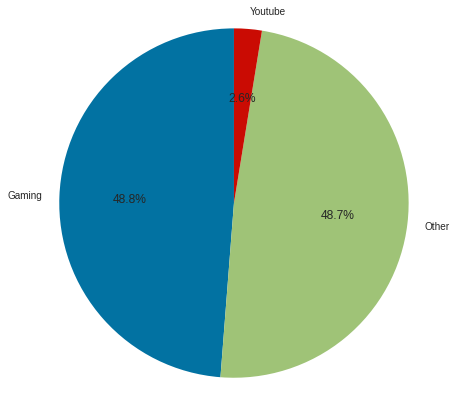

In [55]:
fig1, ax1 = plt.subplots(figsize=(7,7))
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
ax1.axis('equal')
plt.show()